In [1]:
from sklearn.decomposition import PCA
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
# from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2024-07-12 16:48:41.181202: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 16:48:41.638554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 16:48:41.638609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 16:48:41.751588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 16:48:41.907273: I tensorflow/core/platform/cpu_feature_guar

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# import the extracted embeddings first 
# cdr embeddings - valid
cdr_test_mut = np.load("..//saved_output_data//Valid_mut_new_split_CDR.npy")
cdr_test_methyl = np.load("..//saved_output_data//Valid_methyl_new_split_CDR.npy")
cdr_test_gene = np.load("..//saved_output_data//Valid_gene_new_split_CDR.npy")
cdr_test_drugs = np.load("..//saved_output_data//Valid_drug_new_split_CDR.npy")
test_y = np.load("..//saved_output_data//Valid_y.npy")

# gcn embeddings - valid
gcn_test_cnv = np.load("..//saved_output_data//Valid_cnv_new_split_GCN.npy")
gcn_test_gene = np.load("..//saved_output_data//Valid_gene_new_split_GCN.npy")
gcn_test_drugs = np.load("..//saved_output_data//Valid_drug_new_split_GCN.npy")

In [4]:
cdr_test_mut.shape

(17316, 2010)

In [5]:
cdr_test_gene.shape

(17316, 100)

In [6]:
cdr_test_methyl.shape

(17316, 300)

Need to only use the target domain data - that is embeddings from test set only. Chose the first 10K as train and the rest as test.

In [7]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [8]:
chunks = np.array_split(list(range(0,cdr_test_methyl.shape[0])), 3)

In [9]:
# chunks

In [10]:
test_index = 2

In [11]:
test_items = chunks[test_index]

In [12]:
# test_items

In [13]:
train_items = list(set(list(range(0,cdr_test_methyl.shape[0]))).difference(test_items))

In [14]:
# train_items[-10:]

In [15]:
# CDR
# mutation
cdr_train_mut = cdr_test_mut[train_items,:]
# cdr_valid_mut = cdr_test_mut[10000:13816,:]
cdr_test_mut = cdr_test_mut[test_items,:]
print(cdr_train_mut.shape, cdr_test_mut.shape)

# methylation
cdr_train_methyl = cdr_test_methyl[train_items,:]
# cdr_valid_methyl = cdr_test_methyl[10000:13816,:]
cdr_test_methyl = cdr_test_methyl[test_items,:]
print(cdr_train_methyl.shape,  cdr_test_methyl.shape)

# expression
cdr_train_gene = cdr_test_gene[train_items,:]
# cdr_valid_gene = cdr_test_gene[10000:13816,:]
cdr_test_gene = cdr_test_gene[test_items,:]
print(cdr_train_gene.shape, cdr_test_gene.shape)

# drugs
cdr_train_drugs = cdr_test_drugs[train_items,:]
# cdr_valid_drugs = cdr_test_drugs[10000:13816,:]
cdr_test_drugs = cdr_test_drugs[test_items,:]
print(cdr_train_drugs.shape, cdr_test_drugs.shape)

# GCN
# cnv
gcn_train_cnv = gcn_test_cnv[train_items,:]
# gcn_valid_cnv = gcn_test_cnv[10000:13816,:]
gcn_test_cnv = gcn_test_cnv[test_items,:]
print(gcn_train_cnv.shape, gcn_test_cnv.shape)

# expression
gcn_train_gene = gcn_test_gene[train_items,:]
# gcn_valid_gene = gcn_test_gene[10000:13816,:]
gcn_test_gene = gcn_test_gene[test_items,:]
print(gcn_train_gene.shape, gcn_test_gene.shape)

# drugs
gcn_train_drugs = gcn_test_drugs[train_items,:]
# gcn_valid_drugs = gcn_test_drugs[10000:13816,:]
gcn_test_drugs = gcn_test_drugs[test_items,:]
print(gcn_train_drugs.shape, gcn_test_drugs.shape)

# response
y_train = test_y[train_items,:]
# y_valid = test_y[10000:13816,:]
y_test = test_y[test_items,:]
print(y_train.shape, y_test.shape)

(11544, 2010) (5772, 2010)
(11544, 300) (5772, 300)
(11544, 100) (5772, 100)
(11544, 100) (5772, 100)
(11544, 256) (5772, 256)
(11544, 256) (5772, 256)
(11544, 128) (5772, 128)
(11544, 1) (5772, 1)


In [16]:
y_test.mean()

2.094244087144837

In [17]:
y_test.std()

2.8136855131635183

In [18]:
# define a function to aquire the needed omics, and then fit a PCA - let's not collapse any column in the X_t matrix

def extract_PCA(train_cdr_omics, train_gcn_omics, test_cdr_omics, test_gcn_omics, train_cdr_drug, test_cdr_drug, train_gcn_drug, test_gcn_drug, y_train, y_test, keep_dims = 100):
    # for CDR omics - PCA
    if len(train_cdr_omics) == 1:
        pca_cdr = PCA(n_components=train_cdr_omics[0].shape[1])
        pca_cdr.fit(train_cdr_omics[0])
        cdr_train_omics = pca_cdr.transform(train_cdr_omics[0])[:, :keep_dims]
        # cdr_valid_omics = pca_cdr.transform(valid_cdr_omics[0])[:, :keep_dims]
        cdr_test_omics = pca_cdr.transform(test_cdr_omics[0])[:, :keep_dims]
    elif len(train_cdr_omics) == 2:
        combined_omics_train = np.hstack(train_cdr_omics)
        # combined_omics_valid = np.hstack(valid_cdr_omics)
        combined_omics_test = np.hstack(test_cdr_omics)
        pca_cdr = PCA(n_components=combined_omics_train.shape[1])
        pca_cdr.fit(combined_omics_train)
        cdr_train_omics = pca_cdr.transform(combined_omics_train)[:, :keep_dims]
        # cdr_valid_omics = pca_cdr.transform(combined_omics_valid)[:, :keep_dims]
        cdr_test_omics = pca_cdr.transform(combined_omics_test)[:, :keep_dims]
    else:
        combined_omics_train = np.hstack(train_cdr_omics)
        # combined_omics_valid = np.hstack(valid_cdr_omics)
        combined_omics_test = np.hstack(test_cdr_omics)
        pca_cdr = PCA(n_components=combined_omics_train.shape[1])
        pca_cdr.fit(combined_omics_train)
        cdr_train_omics = pca_cdr.transform(combined_omics_train)[:, :keep_dims]
        # cdr_valid_omics = pca_cdr.transform(combined_omics_valid)[:, :keep_dims]
        cdr_test_omics = pca_cdr.transform(combined_omics_test)[:, :keep_dims]

    # for GCN omics - PCA
    if len(train_gcn_omics) == 1:
        pca_gcn = PCA(n_components=train_gcn_omics[0].shape[1])
        pca_gcn.fit(train_gcn_omics[0])
        gcn_train_omics = pca_gcn.transform(train_gcn_omics[0])[:, :keep_dims]
        # gcn_valid_omics = pca_gcn.transform(valid_gcn_omics[0])[:, :keep_dims]
        gcn_test_omics = pca_gcn.transform(test_gcn_omics[0])[:, :keep_dims]
    else:
        combined_gcn_omics_train = np.hstack(train_gcn_omics)
        # combined_gcn_omics_valid = np.hstack(valid_gcn_omics)
        combined_gcn_omics_test = np.hstack(test_gcn_omics)
        pca_gcn = PCA(n_components=combined_gcn_omics_train.shape[1])
        pca_gcn.fit(combined_gcn_omics_train)
        gcn_train_omics = pca_gcn.transform(combined_gcn_omics_train)[:, :keep_dims]
        # gcn_valid_omics = pca_gcn.transform(combined_gcn_omics_valid)[:, :keep_dims]
        gcn_test_omics = pca_gcn.transform(combined_gcn_omics_test)[:, :keep_dims]

    # note that we are going to have the same drug embeddings, but the original EnKF has different embeddings from separately training the two networks - DualGCN and DeepCDR
    # Let's include two methods for this for now, but need to discuss with Ved about this
    
    # cdr drugs
    pca_cdr_drug = PCA(n_components=train_cdr_drug.shape[1])
    pca_cdr_drug.fit(train_cdr_drug)
    cdr_train_drugs = pca_cdr_drug.transform(train_cdr_drug)[:, :keep_dims]
    # cdr_valid_drugs = pca_cdr_drug.transform(valid_cdr_drug)[:, :keep_dims]
    cdr_test_drugs = pca_cdr_drug.transform(test_cdr_drug)[:, :keep_dims]


    # gcn drugs
    pca_gcn_drug = PCA(n_components=train_gcn_drug.shape[1])
    pca_gcn_drug.fit(train_gcn_drug)
    gcn_train_drugs = pca_gcn_drug.transform(train_gcn_drug)[:, :keep_dims]
    # gcn_valid_drugs = pca_gcn_drug.transform(valid_gcn_drug)[:, :keep_dims]
    gcn_test_drugs = pca_gcn_drug.transform(test_gcn_drug)[:, :keep_dims]

    final_train = [cdr_train_drugs, cdr_train_omics, gcn_train_drugs, gcn_train_omics, y_train.astype("float32")]
    # final_valid = [cdr_valid_drugs, cdr_valid_omics, gcn_valid_drugs, gcn_valid_omics, y_valid.astype("float32")]
    final_test = [cdr_test_drugs, cdr_test_omics, gcn_test_drugs, gcn_test_omics, y_test.astype("float32")]

    return(final_train, final_test)

In [19]:
# let's do this without methylation and cnv data

In [20]:
train_cdr_omics = [cdr_train_gene, cdr_train_methyl, cdr_train_mut]
train_gcn_omics = [gcn_train_cnv, gcn_train_gene]
test_cdr_omics = [cdr_test_gene, cdr_test_methyl, cdr_test_mut]
test_gcn_omics = [gcn_test_cnv, gcn_test_gene]
train_cdr_drug = cdr_train_drugs
test_cdr_drug = cdr_test_drugs
train_gcn_drug = gcn_train_drugs
test_gcn_drug = gcn_test_drugs

In [21]:
%%time
train_list, test_list = extract_PCA(train_cdr_omics, train_gcn_omics, test_cdr_omics, test_gcn_omics, train_cdr_drug,  test_cdr_drug, train_gcn_drug,  test_gcn_drug, y_train, y_test, keep_dims = 100)

CPU times: user 18.1 s, sys: 16.4 s, total: 34.4 s
Wall time: 2.52 s


In [22]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [23]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [24]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [25]:
samp_ann =  ann(hidden = 8, input_shape = 100, output_shape = 1)

2024-07-12 16:48:57.401437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [26]:
weights_ann_1 = samp_ann.get_weights()

In [27]:
h1  = samp_ann.layers[1].output.shape[-1]

In [28]:
h1

8

In [29]:
samp_ann.count_params()

817

In [30]:
hidden_neurons = h1

In [31]:
samp_ann_params = samp_ann.count_params()

In [32]:
def prepare_data_train(catch_train, idxes): 
    # idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    # idxes = list(idxes)
    data1, data2, data3, data4 = catch_train[0][idxes,:], catch_train[1][idxes,:], catch_train[2][idxes,:], catch_train[3][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, data3, data4, y_train 

In [33]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2, data3, data4 = catch_test[0][idxes,:], catch_test[1][idxes,:], catch_test[2][idxes,:], catch_test[3][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, data3, data4, y_train

In [34]:
def prepare_data_valid( catch_valid, size): 
    idxes = random.sample(range(0, catch_valid[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2, data3, data4 = catch_valid[0][idxes,:], catch_valid[1][idxes,:], catch_valid[2][idxes,:], catch_valid[3][idxes,:]
    y_valid = catch_valid[-1][idxes].reshape(-1,1)
    return data1, data2, data3, data4, y_valid

In [35]:
train_idxes = random.sample(range(0, train_list[0].shape[0]), k = train_list[0].shape[0])

In [36]:
data1_traina, data2_traina, data3_traina, data4_traina, y_traina =  prepare_data_train(train_list, train_idxes)

In [37]:
data1_test, data2_test, data3_test, data4_test, y_test =  prepare_data_test(test_list, size = test_list[0].shape[0])

In [38]:
def get_initial_X_t(data1, data2, data3, data4, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2_zero,1),
                                                       np.expand_dims(initial_ensembles_for_D3_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [39]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [40]:
from scipy.stats import beta

In [41]:
fudging_beta = beta(1,9)

In [42]:
def forward_operation(data1, data2, data3, data4, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
    model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2, model_3, model_4

In [43]:
def forward_operation_test(data1, data2, data3, data4, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
    model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    return X_t, initial_ensembles, final_output, model_1, model_2, model_3, model_4

In [44]:
total_weights = 4*(samp_ann.count_params() + 1 + 1)

In [45]:
reduction = 50

In [46]:
size_ens = total_weights//reduction
# total_weights//reduction

In [47]:
size_ens

65

In [48]:
G_t = [[1, 1, 1, 1]]
G_t = np.array(G_t).T

In [49]:
G_t.shape

(4, 1)

In [50]:
def get_predictions(data1, data2, data3, data4, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2, w3, w4

In [51]:
def get_predictions_test(data1, data2, data3, data4, initial_ensembles): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation_test(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2, w3, w4

In [52]:
def calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _, _, _ = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [53]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [54]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [55]:
target_dim = 1

In [56]:
lambda_D = 1

In [57]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [58]:
def get_updated_ensemble(data1, data2, data3, data4, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [59]:
from joblib import Parallel, delayed

In [60]:
# idx = 1

In [61]:
from scipy.stats import pearsonr

In [62]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [63]:
batch_size = 2500

In [64]:
import random

In [65]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    

    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    w1_catch = []
    w2_catch = []
    w3_catch = []
    w4_catch = []
    
    
    train_idxes = random.sample(range(0, train_list[0].shape[0]), k = train_list[0].shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    best_rmse_train = 10000
    
    data1_train, data2_train, data3_train, data4_train, y_train = prepare_data_train(train_list, train_chunks[0])
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train, data3_train, data4_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
        
            data1_train, data2_train, data3_train, data4_train, y_train = prepare_data_train(train_list, chunk)

            initial_ensembles = get_updated_ensemble(data1_train, data2_train, data3_train, data4_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
            G_u_train, w1, w2, w3, w4 = get_predictions(data1_traina, data2_traina, data3_traina, data4_traina, initial_ensembles, fudging_beta)
    
            li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
            ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
            width_train = ui_train - li_train
            avg_width_train = width_train.mean(0)[0]
    
            ind_train = (y_traina >= li_train) & (y_traina <= ui_train)
            coverage_train= ind_train.mean(0)[0]
    
            averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
            rmse_train = np.sqrt(((y_traina -averaged_targets_train)**2).mean(0))[0]
        
            pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_traina.reshape(y_traina.shape[0],))
        
            r_train = pearsonr_train[0]
    
            G_u_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, initial_ensembles)
    

    
            li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
            ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
            width_test = ui_test - li_test
            avg_width_test = width_test.mean(0)[0]
    
            ind_test = (y_test >= li_test) & (y_test <= ui_test)
            coverage_test= ind_test.mean(0)[0]
    
            averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
            rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
            pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
            r_test = pearsonr_test[0]
            
            train_rmse.append(rmse_train)
            
            test_rmse.append(rmse_test)
            
            
            if print_true == True:
                print("Training Coverage, Widths, RMSE, and Pearson R")
                print(coverage_train, avg_width_train, rmse_train, r_train)
                print("Testing Coverage, Widths, RMSE, and Pearson R")
                print(coverage_test, avg_width_test, rmse_test, r_test)
                print("Weight 1 Stats")
                print(w1.mean(), w1.std())
                print("Weight 2 Stats")
                print(w2.mean(), w2.std())
                print("Weight 3 Stats")
                print(w3.mean(), w3.std())
                print("Weight 4 Stats")
                print(w4.mean(), w4.std())
            
            w1_catch.append([w1.mean(), w1.std()])
            w2_catch.append([w2.mean(), w2.std()])
            w3_catch.append([w3.mean(), w3.std()])
            w4_catch.append([w4.mean(), w4.std()])
            

            if (rmse_train < best_rmse_train): 
                best_pearsonr_train = r_train
            # print("went here")
                best_train_width_mean = avg_width_train.mean()
                best_train_width = avg_width_train
                # best_smiles_weight = w1.mean()
                best_coverage_train = coverage_train
                best_rmse_train = rmse_train
                best_pearson_r = r_test
                best_test_width = avg_width_test

                best_coverage_test = coverage_test    
                best_rmse_test = rmse_test
                patience = 0
                best_ensembles = initial_ensembles
                
                best_w1_weight = w1.mean()
                best_w2_weight = w2.mean()
                best_w3_weight = w3.mean()
                best_w4_weight = w4.mean()
                
                best_test_preds = averaged_targets_test
                best_li = li_test
                best_ui = ui_test
                
                best_residuals = (y_test -averaged_targets_test)
            
            else:
                patience = patience + 1
            
            if print_true == True:
                print("Patience is")
                print(patience)
                print('\n')
        
            if patience > threshold:
                # print("train_coverage" + str(best_coverage_train), flush = True)
                print("test_coverage" + str(best_coverage_test), flush = True)
                # print("train_width" + str(best_train_width.tolist()), flush = True)
                print("test_width" + str(best_test_width), flush = True)
                # print("smiles_weight" + str(best_smiles_weight), flush = True)
                # print("rmse_train" + str(best_rmse_train.tolist()), flush = True)
                print("rmse_test" + str(best_rmse_test), flush = True)
                print("pearson_r_test" + str(best_pearson_r), flush = True)
                weights = [best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight]
                print("weights", flush = True)
                print(weights, flush = True)
                print('\n', flush = True)
                # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
                test_preds = ui_test
            
                return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, w1_catch, w2_catch, w3_catch, w4_catch, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight, best_test_preds, best_li, best_ui, best_residuals]


## can tune the threshold here

In [66]:
threshold = 10

In [67]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,  \
best_ensembles, train_rmse, test_rmse,   w1_catch, w2_catch, w3_catch, w4_catch, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight, best_test_preds, best_li, best_ui, best_residuals = get_results(0, var_weights = 1.0, var_weight_weights = 0.20, var_D = 1.0, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 0.0125, print_true = True)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
0.14708939708939708 1.8103741475952737 3.674296302496111 -0.20024439463672264
Testing Coverage, Widths, RMSE, and Pearson R
0.14743589743589744 1.797093452364447 3.6626797426926494 -0.18713141342565734
Weight 1 Stats
0.20540950718938183 0.02062732049052061
Weight 2 Stats
0.24278061349584099 0.022572907493972613
Weight 3 Stats
0.25486527231270845 0.02391862953498154
Weight 4 Stats
0.29694460700206876 0.027942860390106867
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.279019404019404 2.458401286995375 2.8789675671819737 0.25081531496321163
Testing Coverage, Widths, RMSE, and Pearson R
0.2758142758142758 2.452111388459497 2.8348704031108736 0.2810236009512236
Weight 1 Stats
0.22220066155171078 0.02943984097676486
Weight 2 Stats
0.1923320232314939 0.0190668202849639
Weight 3 Stats
0.3874764194425347 0.03606142082127719
Weight 4 Stats
0.19799089577426054 0.022850672328005427
Patience is
0


Training Coverage,

In [68]:
# save the outputs from here 

In [69]:
# best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,  \
# best_ensembles, train_rmse, test_rmse,   w1_catch, w2_catch, w3_catch, w4_catch, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight, best_test_preds, best_li, best_ui, best_residuals

In [70]:
col_names = ['best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 'best_w1_weight', 'best_w2_weight', 'best_w3_weight', 'best_w4_weight']

In [71]:
col_values = [best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_w1_weight, best_w2_weight, best_w3_weight, best_w4_weight]

In [72]:
print('best_test_width' , best_test_width)

best_test_width 4.162358207870693


In [73]:
Menkf_test_results = pd.DataFrame({'parameter': col_names, 'value': col_values})
save_name = 'test_parameters_all_features_for_test_fold_' + str(test_index) + '.csv'
save_path = '../MEnKF_fold_results/Fold_2/'
Menkf_test_results.to_csv(save_path + save_name, index = False)

In [74]:
best_test_preds.shape

(5772, 1)

In [75]:
best_test_preds

array([[3.44440797],
       [0.66301698],
       [1.94531445],
       ...,
       [4.68024732],
       [1.16499601],
       [1.90466546]])

In [76]:
# Scatterplot plots predicted and actual log IC50 of the test set

In [77]:
# get the preds wit best ensemble weights
preds_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, best_ensembles)

In [78]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

In [79]:
averaged_preds_test.shape

(5772, 1)

In [80]:
# save these preds?
np.save(save_path + 'test_preds_all_features_for_test_fold_' + str(test_index) + '.npy', averaged_preds_test)

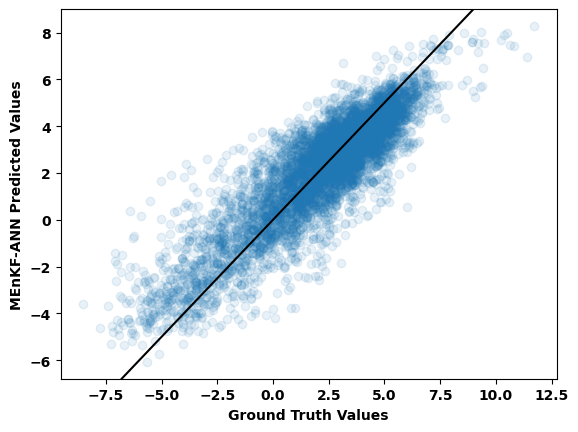

In [81]:
fig = plt.figure()
plt.scatter(y_test, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values", fontweight = "bold",fontsize = 10)
plt.ylabel("MEnKF-ANN Predicted Values", fontweight = "bold", fontsize = 10)
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
fig.savefig(save_path + 'MEnKF_AllFeatures_Scatterplot_' + str(test_index) + '.pdf', bbox_inches='tight', format = "pdf", dpi = 1000)
plt.show()

In [82]:
# Residual hisogram

In [83]:
from scipy.optimize import curve_fit

In [84]:
# save the residuals
np.save(save_path + 'test_best_residuals_all_features_for_test_fold_' + str(test_index) + '.npy', best_residuals)

In [85]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

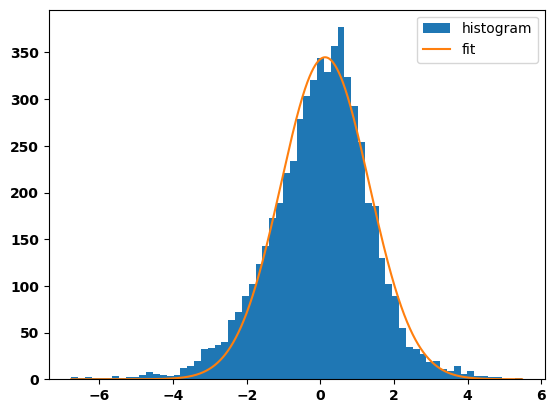

In [86]:
fig = plt.figure()
bin_heights, bin_borders, _ = plt.hist(best_residuals, bins='auto', label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
fig.savefig(save_path + 'MEnKF_AllFeatures_residual_hist_' + str(test_index) + '.pdf', bbox_inches='tight', format = "pdf", dpi = 1000)
plt.legend()
plt.show()

In [87]:
# Plot of confidence intervals, with observed values

In [88]:
catch_data = np.hstack((y_test, best_li, best_ui))

In [89]:
catch_data_df = pd.DataFrame(catch_data, columns = [ 'true_val', 'lower_CI', 'upper_CI'])

In [90]:
catch_data_df = catch_data_df.sort_values('true_val')

In [91]:
# save the df
catch_data_df.to_csv(save_path + 'CI_infor_all_features_' + str(test_index) + '.csv' , index = False)

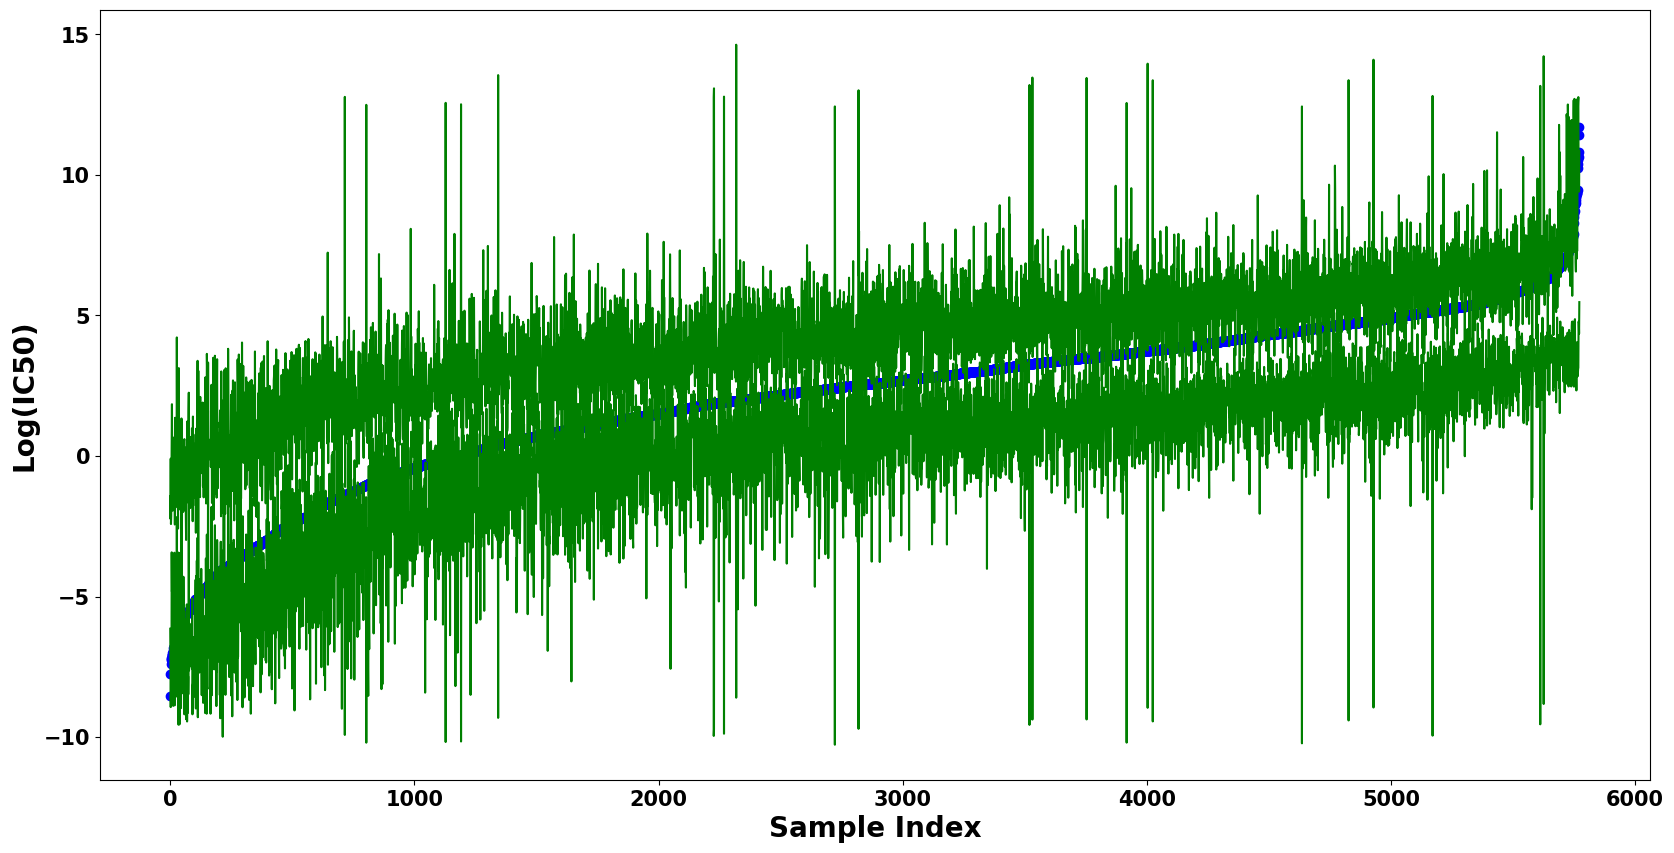

In [92]:
fig= plt.figure(figsize = (20,10))
# plt.figure(figsize = (20,10))
# fig, axs = plt.subplots(4, 2)
plt.scatter(range(0,catch_data_df.shape[0]), catch_data_df['true_val'],  c = "blue", label = "IC50")
plt.plot(range(0,catch_data_df.shape[0]), catch_data_df['lower_CI'],   c = "green",
            label = "Lower Prediction Interval")
plt.plot(range(0,catch_data_df.shape[0]), catch_data_df['upper_CI'],   c = "green",
            label = "Upper Prediction Interval")
# plt.fill_between(range(0,combo_df1.shape[0]), combo_df1["LI_IC50_Pred"].values, combo_df1["UI_IC50_Pred"].values,
#                  color = "green", label = "Empirical 95 % Prediction Interval",alpha=0.6)

plt.xlabel("Sample Index", fontsize = 20, fontweight = "bold")
plt.ylabel("Log(IC50)", fontsize = 20, fontweight = "bold")
plt.xticks( fontsize = 15, fontweight = "bold")
plt.yticks( fontsize = 15, fontweight = "bold")
fig.savefig(save_path + 'MEnKF_AllFeatures_CI_plot_' + str(test_index) + '.pdf', bbox_inches='tight', format = "pdf", dpi = 1000)
plt.show()